# Data Loading
This opening cell imports pandas, defines the expected columns, and ingests `cycling.txt` so every subsequent analysis references the same cleaned DataFrame.

In [33]:
import pandas as pd
from pathlib import Path

# Load the race points log into a pandas DataFrame
DATA_PATH = Path("cycling.txt")
COLUMNS = [
    "all_riders",
    "rider_class",
    "stage",
    "points",
    "stage_class",
]

df = pd.read_csv(
    DATA_PATH,
    sep=" ",
    skipinitialspace=True,
    engine="python",
    quotechar='"',
    names=COLUMNS,
    skiprows=1,
    comment="/",
    encoding="utf-8",
)

print(f"Loaded {len(df):,} rows from {DATA_PATH.name}.")
df.head()

Loaded 3,496 rows from cycling.txt.


,all_riders,rider_class,stage,points,stage_class
0,Tadej Pogačar,All Rounder,X1,15,flat
1,Tadej Pogačar,All Rounder,X2,219,hills
2,Tadej Pogačar,All Rounder,X3,34,flat
3,Tadej Pogačar,All Rounder,X4,264,hills
4,Tadej Pogačar,All Rounder,X6,114,hills


### Environment Setup
Installing statsmodels, seaborn, and scipy up front keeps the notebook self-contained when rerun on a new machine.

In [21]:
%pip install --quiet statsmodels seaborn scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Dataset Overview
Before diving into rider-specific visuals and modeling, we summarise the entire dataset: size, rider/stage coverage, and how points distribute across stage and rider classes. The goal is to give a high-level picture and ensure no obvious data issues.

,rows,unique_riders,unique_stages,avg_points,median_points,std_points
0,3496,184,19,12.39,0.0,36.29


,rider_class,stage_entries
0,Unclassed,2185
1,Sprinter,551
2,Climber,437
3,All Rounder,323


,stage_class,stage_entries
0,hills,1472
1,flat,1104
2,mount,920


,stage_class,sum_points,mean_points,median_points,std_points
0,flat,13021,11.79,0.0,33.22
1,hills,18430,12.52,0.0,36.13
2,mount,11848,12.88,0.0,39.91


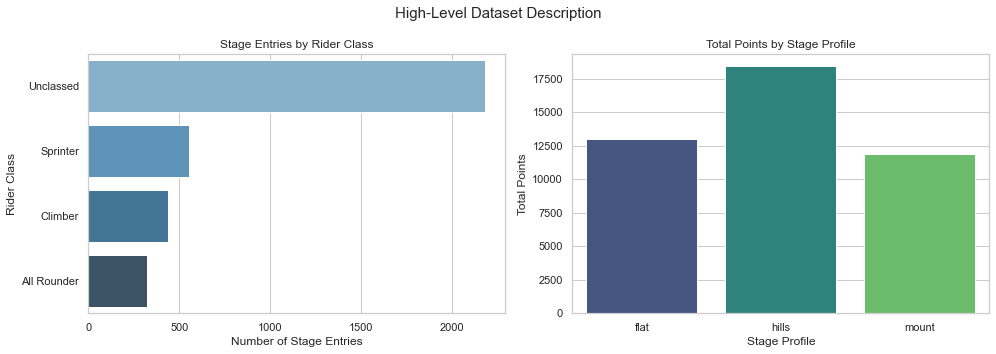

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

dataset_summary = {
    "rows": len(df),
    "unique_riders": df["all_riders"].nunique(),
    "unique_stages": df["stage"].nunique(),
    "avg_points": round(df["points"].mean(), 2),
    "median_points": round(df["points"].median(), 2),
    "std_points": round(df["points"].std(), 2),
}

rider_counts = (
    df["rider_class"].value_counts()
    .rename_axis("rider_class")
    .reset_index(name="stage_entries")
    .sort_values("stage_entries", ascending=False)
)

stage_counts = (
    df["stage_class"].value_counts()
    .rename_axis("stage_class")
    .reset_index(name="stage_entries")
    .sort_values("stage_entries", ascending=False)
)

points_by_stage = (
    df.groupby("stage_class")["points"]
    .agg(sum_points="sum", mean_points="mean", median_points="median", std_points="std")
    .round(2)
    .reset_index()
)

display(pd.DataFrame([dataset_summary]))
display(rider_counts)
display(stage_counts)
display(points_by_stage)

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(
    data=rider_counts,
    x="stage_entries",
    y="rider_class",
    palette="Blues_d",
    ax=axes[0]
)
axes[0].set_title("Stage Entries by Rider Class")
axes[0].set_xlabel("Number of Stage Entries")
axes[0].set_ylabel("Rider Class")

sns.barplot(
    data=points_by_stage,
    x="stage_class",
    y="sum_points",
    palette="viridis",
    ax=axes[1]
)
axes[1].set_title("Total Points by Stage Profile")
axes[1].set_xlabel("Stage Profile")
axes[1].set_ylabel("Total Points")

fig.suptitle("High-Level Dataset Description", fontsize=15)
plt.tight_layout()
plt.show()

## Summary Statistics & Distributions
The tables below report mean/median/variance/standard deviation of points by rider and stage class, followed by a cross-tab of average points for every rider-class × stage-class combination. Histograms and boxplots then show how the points distribute overall and across classes.

,mean,median,variance,std,iqr,skew
Overall,12.39,0.0,1316.63,36.29,8.0,4.49


,mean,median,variance,std,iqr,skew,count
rider_class,,,,,,,
All Rounder,37.69,12.0,4091.09,63.96,39.5,2.27,323
Climber,20.17,6.0,1887.66,43.45,16.0,3.36,437
Sprinter,15.04,0.0,1749.94,41.83,4.0,3.66,551
Unclassed,6.42,0.0,542.08,23.28,2.0,6.61,2185


,mean,median,variance,std,iqr,skew,count
stage_class,,,,,,,
mount,12.88,0.0,1592.54,39.91,4.0,4.54,920
hills,12.52,0.0,1305.40,36.13,8.0,4.35,1472
flat,11.79,0.0,1103.52,33.22,8.0,4.50,1104


,stage_entries,share_pct
Unclassed,2185,62.50
Sprinter,551,15.76
Climber,437,12.50
All Rounder,323,9.24


mean  median    std    iqr  count
rider_class stage_class                                    
All Rounder flat         15.44     8.0  28.28  19.25    102
            hills        35.79    12.5  57.46  41.50    136
            mount        67.42    17.0  88.96  99.00     85
Climber     flat          5.09     1.5   6.23   8.75    138
            hills        21.67     7.0  45.98  16.50    184
            mount        35.86    12.0  57.02  36.00    115
Sprinter    flat         38.98     2.5  63.59  50.00    174
            hills         5.20     0.0  21.95   2.00    232
            mount         2.04     0.0   5.89   0.00    145
Unclassed   flat          5.74     0.0  19.80   3.75    690
            hills         9.10     0.0  30.66   3.00    920
            mount         2.95     0.0   7.91   0.00    575

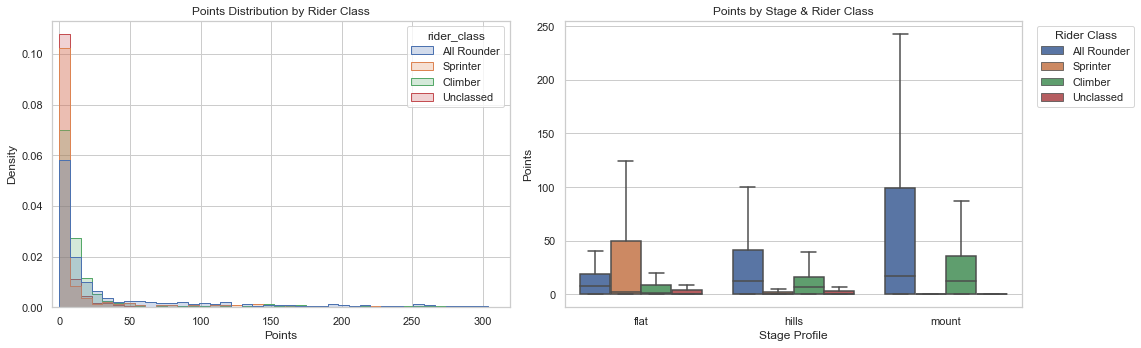

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def iqr(series):
    return series.quantile(0.75) - series.quantile(0.25)

global_summary = pd.DataFrame(
    {
        "mean": [df["points"].mean()],
        "median": [df["points"].median()],
        "variance": [df["points"].var()],
        "std": [df["points"].std()],
        "iqr": [iqr(df["points"])],
        "skew": [df["points"].skew()]
    },
    index=["Overall"]
).round(2)

summary_by_rider = (
    df.groupby("rider_class")["points"]
    .agg(
        mean="mean",
        median="median",
        variance="var",
        std="std",
        iqr=iqr,
        skew="skew",
        count="count"
    )
    .round(2)
    .sort_values("mean", ascending=False)
)

summary_by_stage = (
    df.groupby("stage_class")["points"]
    .agg(
        mean="mean",
        median="median",
        variance="var",
        std="std",
        iqr=iqr,
        skew="skew",
        count="count"
    )
    .round(2)
    .sort_values("mean", ascending=False)
)

stage_share = (
    df["rider_class"]
    .value_counts()
    .rename("stage_entries")
    .to_frame()
)
stage_share["share_pct"] = (stage_share["stage_entries"] / len(df) * 100).round(2)

rider_stage_stats = (
    df.groupby(["rider_class", "stage_class"])["points"]
    .agg(mean="mean", median="median", std="std", iqr=iqr, count="count")
    .round(2)
)

mean_matrix = rider_stage_stats["mean"].unstack()

display(global_summary)
display(summary_by_rider)
display(summary_by_stage)
display(stage_share)
display(rider_stage_stats)

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(
    data=df,
    x="points",
    hue="rider_class",
    element="step",
    stat="density",
    common_norm=False,
    bins=40,
    ax=axes[0]
)
axes[0].set_title("Points Distribution by Rider Class")
axes[0].set_xlabel("Points")
axes[0].set_ylabel("Density")
axes[0].set_xlim(-5, df["points"].max() * 1.05)

sns.boxplot(
    data=df,
    x="stage_class",
    y="points",
    hue="rider_class",
    showfliers=False,
    ax=axes[1]
)
axes[1].set_title("Points by Stage & Rider Class")
axes[1].set_xlabel("Stage Profile")
axes[1].set_ylabel("Points")
axes[1].legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="Rider Class")

plt.tight_layout()
plt.show()

### Distribution Comparisons & Interaction Views
Visual diagnostics emphasize class × stage interactions: staged boxplots for within-stage spreads, an interaction plot of stage means per rider class, and a heatmap of the mean matrix for quick scanning.

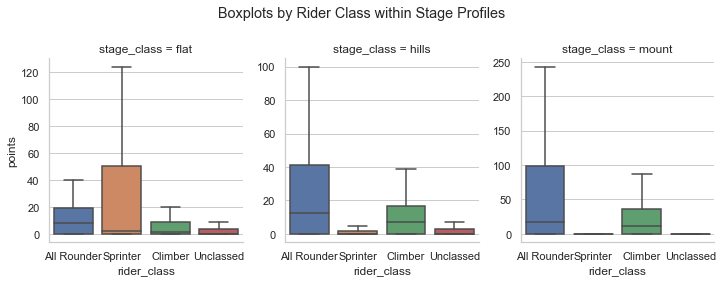

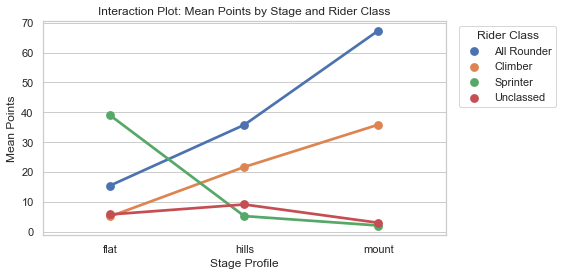

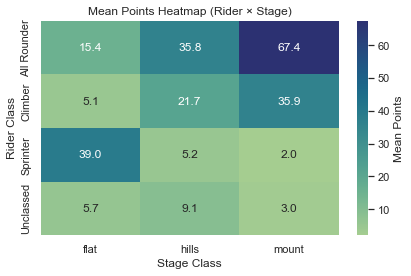

In [36]:
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=df,
    x="rider_class",
    y="points",
    col="stage_class",
    kind="box",
    sharey=False,
    showfliers=False,
    height=4,
    aspect=0.85
 )
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Boxplots by Rider Class within Stage Profiles")

interaction_means = (
    df.groupby(["stage_class", "rider_class"])["points"]
    .mean()
    .reset_index(name="mean_points")
)

plt.figure(figsize=(8, 4))
sns.pointplot(
    data=interaction_means,
    x="stage_class",
    y="mean_points",
    hue="rider_class",
    markers="o",
    linestyles="-"
)
plt.title("Interaction Plot: Mean Points by Stage and Rider Class")
plt.xlabel("Stage Profile")
plt.ylabel("Mean Points")
plt.legend(title="Rider Class", bbox_to_anchor=(1.02, 1))
plt.tight_layout()

plt.figure(figsize=(6, 4))
sns.heatmap(
    mean_matrix,
    annot=True,
    fmt=".1f",
    cmap="crest",
    cbar_kws={"label": "Mean Points"}
)
plt.title("Mean Points Heatmap (Rider × Stage)")
plt.xlabel("Stage Class")
plt.ylabel("Rider Class")
plt.tight_layout()

## Rider Points Visualizations
Summaries below highlight (1) the riders accumulating the most total points and (2) how different rider classes contribute across stage profiles.

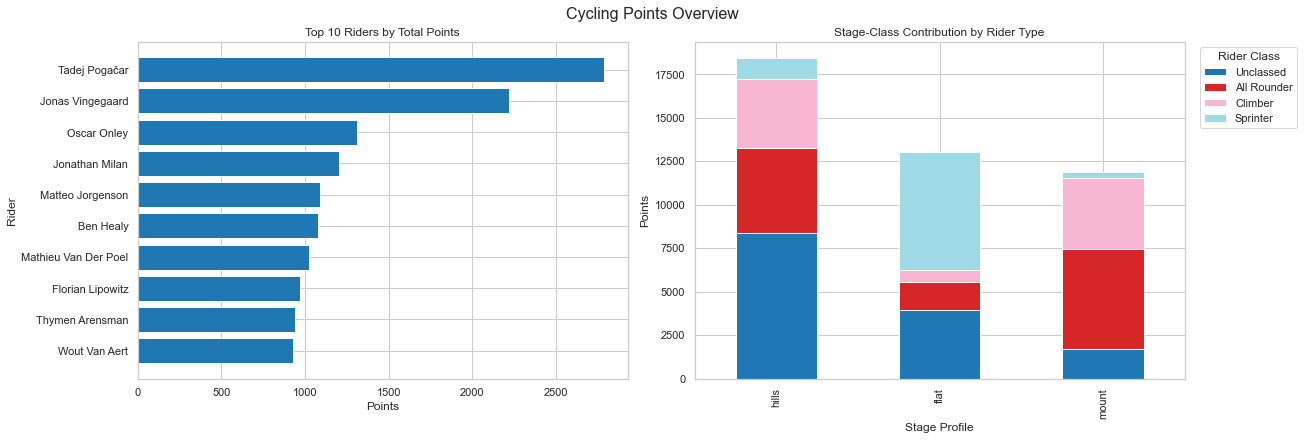

In [32]:
import matplotlib.pyplot as plt

# Aggregate rider totals and rider-class contributions per stage profile
top_riders = (
    df.groupby("all_riders", as_index=False)["points"]
    .sum()
    .sort_values("points", ascending=False)
    .head(10)
)

stage_class_mix = (
    df.groupby(["stage_class", "rider_class"], as_index=False)["points"]
    .sum()
)

stage_class_pivot = (
    stage_class_mix
    .pivot(index="stage_class", columns="rider_class", values="points")
    .fillna(0)
)

stage_order = stage_class_pivot.sum(axis=1).sort_values(ascending=False).index
class_order = stage_class_pivot.sum(axis=0).sort_values(ascending=False).index
stage_class_pivot = stage_class_pivot.loc[stage_order, class_order]

fig, axes = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)

top_riders_sorted = top_riders.sort_values("points")
axes[0].barh(
    top_riders_sorted["all_riders"],
    top_riders_sorted["points"],
    color="#1f77b4"
)
axes[0].set_title("Top 10 Riders by Total Points")
axes[0].set_xlabel("Points")
axes[0].set_ylabel("Rider")

stage_class_pivot.plot(
    kind="bar",
    stacked=True,
    ax=axes[1],
    colormap="tab20"
)
axes[1].set_title("Stage-Class Contribution by Rider Type")
axes[1].set_xlabel("Stage Profile")
axes[1].set_ylabel("Points")
axes[1].legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="Rider Class")

fig.suptitle("Cycling Points Overview", fontsize=16)
plt.show()

## Descriptive Analysis
To assess whether rider classes perform differently across stage profiles, we summarise rider-class × stage-class points with central tendency, dispersion, and share-of-total metrics. This provides context before formal hypothesis testing.

,count,mean,median,std,min,max,sum
rider_class,,,,,,,
All Rounder,323,37.69,12.0,63.96,0,304,12173
Climber,437,20.17,6.0,43.45,0,269,8814
Sprinter,551,15.04,0.0,41.83,0,272,8285
Unclassed,2185,6.42,0.0,23.28,0,260,14027


count   mean  median    std  min  max   sum
stage_class rider_class                                             
flat        All Rounder    102  15.44     8.0  28.28    0  194  1575
            Climber        138   5.09     1.5   6.23    0   26   703
            Sprinter       174  38.98     2.5  63.59    0  272  6782
            Unclassed      690   5.74     0.0  19.80    0  232  3961
hills       All Rounder    136  35.79    12.5  57.46    0  274  4867
            Climber        184  21.67     7.0  45.98    0  264  3987
            Sprinter       232   5.20     0.0  21.95    0  244  1207
            Unclassed      920   9.10     0.0  30.66    0  260  8369
mount       All Rounder     85  67.42    17.0  88.96    0  304  5731
            Climber        115  35.86    12.0  57.02    0  269  4124
            Sprinter       145   2.04     0.0   5.89    0   32   296
            Unclassed      575   2.95     0.0   7.91    0   64  1697

rider_class,All Rounder,Climber,Sprinter,Unclassed
stage_class,,,,
flat,12.1,5.4,52.1,30.4
hills,26.4,21.6,6.5,45.4
mount,48.4,34.8,2.5,14.3


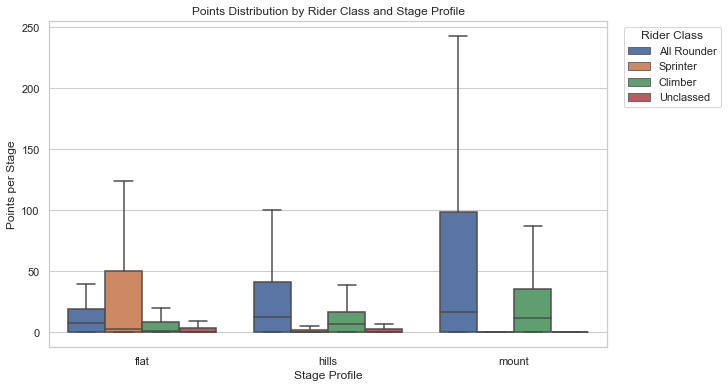

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Overall rider-class performance
overall_stats = (
    df.groupby("rider_class")["points"]
    .agg(["count", "mean", "median", "std", "min", "max", "sum"])
    .sort_values("mean", ascending=False)
)

# Stage-by-rider breakdown
stage_stats = (
    df.groupby(["stage_class", "rider_class"])["points"]
    .agg(["count", "mean", "median", "std", "min", "max", "sum"])
    .round(2)
)

share_of_stage = (
    df.groupby(["stage_class", "rider_class"])["points"].sum()
    .groupby(level=0)
    .apply(lambda s: 100 * s / s.sum())
    .unstack()
    .round(1)
)

display(overall_stats.round(2))
display(stage_stats)
display(share_of_stage)

# Visualize rider performance per stage profile
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x="stage_class",
    y="points",
    hue="rider_class",
    showfliers=False,
)
plt.title("Points Distribution by Rider Class and Stage Profile")
plt.xlabel("Stage Profile")
plt.ylabel("Points per Stage")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="Rider Class")
plt.show()

### Interaction & Faceted Visuals
The next cell highlights rider × stage patterns via a mean interaction line plot plus stage-faceted boxplots to contrast distributional spread.

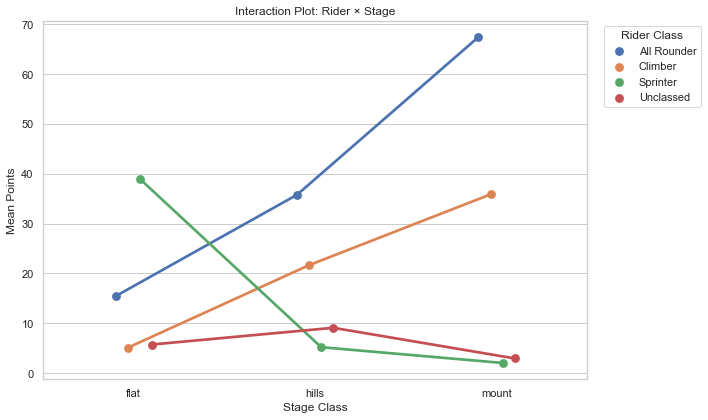

Text(0.5, 0.98, 'Faceted Boxplots by Stage Profile')

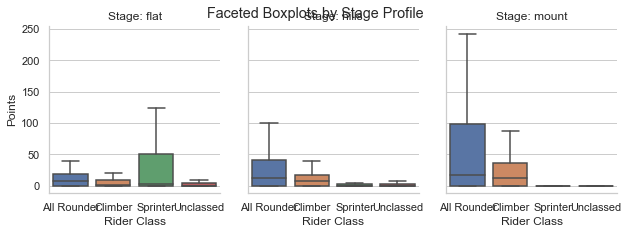

In [39]:
# High-impact visuals: interaction plot + faceted boxplots
interaction_means = (
    df.groupby(["stage_class", "rider_class"])["points"].mean().reset_index()
    .sort_values(["stage_class", "rider_class"])
)

plt.figure(figsize=(10, 6))
sns.pointplot(
    data=interaction_means,
    x="stage_class",
    y="points",
    hue="rider_class",
    dodge=0.2,
    markers="o",
    linestyles="-",
    errorbar=("ci", 95),
)
plt.title("Interaction Plot: Rider × Stage")
plt.xlabel("Stage Class")
plt.ylabel("Mean Points")
plt.legend(title="Rider Class", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

g = sns.catplot(
    data=df,
    x="rider_class",
    y="points",
    col="stage_class",
    col_wrap=3,
    kind="box",
    sharey=True,
    height=3.3,
    aspect=0.9,
    showfliers=False,
    order=df.groupby("rider_class")["points"].mean().sort_values(ascending=False).index,
)
g.set_axis_labels("Rider Class", "Points")
g.set_titles("Stage: {col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Faceted Boxplots by Stage Profile")

## Hypothesis Testing
Two research questions guide the inferential step:
1. **Do rider classes differ in their average points across all stages?**
2. **Does stage profile change the relative performance between rider classes (interaction effect)?**
We use an ordinary least squares model with categorical factors (`rider_class`, `stage_class`) to perform one-way and two-way ANOVA-style F-tests. The data volume is large, but we check assumptions and note limitations in the narrative.

In [40]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats
import statsmodels.api as sm

# One-way ANOVA: rider class main effect
model_class = smf.ols("points ~ C(rider_class)", data=df).fit()
anova_class = anova_lm(model_class, typ=2)

# One-way ANOVA: stage class main effect
model_stage = smf.ols("points ~ C(stage_class)", data=df).fit()
anova_stage = anova_lm(model_stage, typ=2)

# Two-way ANOVA with interaction: rider + stage profile
model_interaction = smf.ols(
    "points ~ C(rider_class) * C(stage_class)",
    data=df
).fit()
anova_interaction = anova_lm(model_interaction, typ=2)

def eta_tables(anova_table):
    residual_ss = anova_table.loc["Residual", "sum_sq"]
    total_ss = anova_table["sum_sq"].sum()
    rows = []
    for effect in anova_table.index:
        if effect == "Residual":
            continue
        ss = anova_table.loc[effect, "sum_sq"]
        rows.append({
            "effect": effect,
            "eta_sq": ss / total_ss,
            "partial_eta_sq": ss / (ss + residual_ss)
        })
    return pd.DataFrame(rows)

eta_class = eta_tables(anova_class)
eta_stage = eta_tables(anova_stage)
eta_interaction = eta_tables(anova_interaction)

# Residual diagnostics (using two-way model)
residuals = model_interaction.resid
sample_resid = residuals.sample(n=min(5000, len(residuals)), random_state=42)
shapiro_stat = stats.shapiro(sample_resid)
qq = sm.ProbPlot(residuals)

rider_groups = [group["points"].values for _, group in df.groupby("rider_class")]
stage_groups = [group["points"].values for _, group in df.groupby("stage_class")]
levene_rider = stats.levene(*rider_groups, center="median")
levene_stage = stats.levene(*stage_groups, center="median")

# Kruskal-Wallis as robustness checks
kw_rider = stats.kruskal(*rider_groups)
kw_stage = stats.kruskal(*stage_groups)
stage_group_tests = {}
for stage_name, stage_df in df.groupby("stage_class"):
    grouped = [g["points"].values for _, g in stage_df.groupby("rider_class") if len(g) > 0]
    h_stat, p_value = stats.kruskal(*grouped)
    stage_group_tests[stage_name] = {"H": h_stat, "p": p_value}

display(anova_class.round(3))
display(eta_class.round(3))
display(anova_stage.round(3))
display(eta_stage.round(3))
display(anova_interaction.round(3))
display(eta_interaction.round(3))
print("Shapiro-Wilk p-value (interaction residuals):", round(shapiro_stat.pvalue, 4))
print("Levene rider-class p-value:", round(levene_rider.pvalue, 4))
print("Levene stage-class p-value:", round(levene_stage.pvalue, 4))
print("Kruskal-Wallis rider p-value:", round(kw_rider.pvalue, 4))
print("Kruskal-Wallis stage p-value:", round(kw_stage.pvalue, 4))
stage_group_tests

,sum_sq,df,F,PR(>F)
C(rider_class),314893.689,3.0,85.505,0.0
Residual,4286712.315,3492.0,NaN,NaN


,effect,eta_sq,partial_eta_sq
0,C(rider_class),0.068,0.068


,sum_sq,df,F,PR(>F)
C(stage_class),635.925,2.0,0.241,0.786
Residual,4600970.079,3493.0,NaN,NaN


,effect,eta_sq,partial_eta_sq
0,C(stage_class),0.0,0.0


,sum_sq,df,F,PR(>F)
C(rider_class),314893.689,3.0,92.816,0.000
C(stage_class),635.925,2.0,0.281,0.755
C(rider_class):C(stage_class),346064.618,6.0,51.002,0.000
Residual,3940011.771,3484.0,NaN,NaN


,effect,eta_sq,partial_eta_sq
0,C(rider_class),0.068,0.074
1,C(stage_class),0.000,0.000
2,C(rider_class):C(stage_class),0.075,0.081


Shapiro-Wilk p-value (interaction residuals): 0.0
Levene rider-class p-value: 0.0
Levene stage-class p-value: 0.7855
Kruskal-Wallis rider p-value: 0.0
Kruskal-Wallis stage p-value: 0.0086


{'flat': {'H': 82.09679179120823, 'p': 1.089451564890935e-17},
 'hills': {'H': 156.39521512731392, 'p': 1.0990389345584899e-33},
 'mount': {'H': 183.16057595089578, 'p': 1.8318686772581686e-39}}

### Effect Sizes & Robust F-tests
We complement the classical ANOVA with bootstrap partial $\eta^2$ confidence intervals and HC3-robust Wald tests to quantify magnitude and guard against heteroskedasticity.

In [43]:
from numpy.random import default_rng
from statsmodels.stats.anova import anova_lm
from scipy import stats
from patsy import dmatrix
from statsmodels.stats.multitest import multipletests
from itertools import combinations, product
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Bootstrap partial eta-squared CIs and HC3-robust Wald tests
def bootstrap_partial_eta_ci(data, formula, effect, n_boot=300, seed=42):
    rng = default_rng(seed)
    estimates = []
    for _ in range(n_boot):
        sample_idx = rng.integers(0, len(data), len(data))
        sample = data.iloc[sample_idx]
        boot_model = smf.ols(formula, data=sample).fit()
        boot_anova = anova_lm(boot_model, typ=2)
        ss_effect = boot_anova.loc[effect, "sum_sq"]
        ss_resid = boot_anova.loc["Residual", "sum_sq"]
        estimates.append(ss_effect / (ss_effect + ss_resid))
    return np.percentile(estimates, [2.5, 97.5])

partial_eta_lookup = dict(zip(eta_interaction["effect"], eta_interaction["partial_eta_sq"]))
effects = ["C(rider_class)", "C(stage_class)", "C(rider_class):C(stage_class)"]
ci_rows = []
for eff in effects:
    ci_low, ci_high = bootstrap_partial_eta_ci(
        df, "points ~ C(rider_class) * C(stage_class)", eff
    )
    ci_rows.append({
        "effect": eff,
        "partial_eta_sq": partial_eta_lookup.get(eff, np.nan),
        "ci_lower": ci_low,
        "ci_upper": ci_high,
    })
partial_eta_ci = pd.DataFrame(ci_rows)

robust_terms = model_interaction.get_robustcov_results(cov_type="HC3").wald_test_terms()
robust_table = robust_terms.summary_frame()

display(partial_eta_ci.round(3))
display(robust_table.round(3))

C:\Users\mirza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


,effect,partial_eta_sq,ci_lower,ci_upper
0,C(rider_class),0.074,0.054,0.098
1,C(stage_class),0.000,0.000,0.002
2,C(rider_class):C(stage_class),0.081,0.061,0.111


,F,P>F,df constraint,df denom
Intercept,[[30.107313195549015]],4.379526324047109e-08,1,3484.0
C(rider_class),[[20.198533641130638]],5.642261370634769e-13,3,3484.0
C(stage_class),[[17.419961285662698]],2.966084487848513e-08,2,3484.0
C(rider_class):C(stage_class),[[23.342819106111904]],3.555099976237718e-27,6,3484.0


### Residual Diagnostics & Modeling Notes
Normality and homoscedasticity diagnostics (Shapiro–Wilk, Levene) accompany QQ plots so we know when to rely on ANOVA p-values versus Kruskal–Wallis or heteroskedasticity-robust alternatives. When repeated measurements per rider matter, upgrade to a random-intercept mixed model (`points ~ rider_class * stage_class + (1|rider)`) to respect within-rider correlation.

## Mixed-Effects Model
Random intercepts per rider ensure repeated stage entries per rider do not inflate Type I error. The fixed portion mirrors the two-way ANOVA (`rider_class * stage_class`).

In [45]:
lmm = smf.mixedlm(
    "points ~ C(rider_class) * C(stage_class)",
    data=df,
    groups=df["all_riders"],
    re_formula="1"
)
try:
    lmm_result = lmm.fit(method="lbfgs", reml=False)
except np.linalg.LinAlgError:
    lmm_result = lmm.fit(method="powell", reml=False, maxiter=200)

lmm_fixed = (
    pd.DataFrame({
        "coef": lmm_result.params,
        "std_err": lmm_result.bse,
        "z": lmm_result.tvalues,
        "p_value": lmm_result.pvalues,
    })
    .round(4)
)

var_random = float(lmm_result.cov_re.iloc[0, 0])
var_resid = float(lmm_result.scale)
icc = var_random / (var_random + var_resid)

print(
    f"Random intercept variance: {var_random:.2f} | Residual variance: {var_resid:.2f} | ICC: {icc:.3f}"
)
display(lmm_fixed)

C:\Users\mirza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\mirza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
C:\Users\mirza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\mirza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)


Random intercept variance: 214.87 | Residual variance: 912.14 | ICC: 0.191


,coef,std_err,z,p_value
Intercept,15.4412,4.6456,3.3238,0.0009
C(rider_class)[T.Climber],-10.3470,6.1265,-1.6889,0.0912
C(rider_class)[T.Sprinter],23.5358,5.8509,4.0226,0.0001
C(rider_class)[T.Unclassed],-9.7006,4.9772,-1.9490,0.0513
C(stage_class)[T.hills],20.3456,3.9559,5.1431,0.0000
C(stage_class)[T.mount],51.9824,4.4355,11.7196,0.0000
C(rider_class)[T.Climber]:C(stage_class)[T.hills],-3.7713,5.2169,-0.7229,0.4697
C(rider_class)[T.Sprinter]:C(stage_class)[T.hills],-54.1200,4.9823,-10.8625,0.0000
C(rider_class)[T.Unclassed]:C(stage_class)[T.hills],-16.9894,4.2383,-4.0086,0.0001
C(rider_class)[T.Climber]:C(stage_class)[T.mount],-21.2157,5.8493,-3.6270,0.0003


## Estimated Marginal Means & Pairwise Contrasts
Model-based means and contrasts communicate which rider classes separate within each stage after balancing sample size differences. Holm-adjusted p-values control family-wise error.

In [47]:
from patsy import build_design_matrices

design_formula = "C(rider_class) * C(stage_class)"
design_info = model_interaction.model.data.design_info
exog_names = model_interaction.model.exog_names
cov_params = model_interaction.cov_params()
params = model_interaction.params.values


def design_vector(rider, stage):
    new_row = pd.DataFrame({"rider_class": [rider], "stage_class": [stage]})
    dm = build_design_matrices([design_info], new_row)[0]
    dm = pd.DataFrame(dm, columns=exog_names)
    return dm.to_numpy().ravel()

stage_levels = sorted(df["stage_class"].unique())
rider_levels = df.groupby("rider_class")["points"].mean().sort_values(ascending=False).index.tolist()

t_crit = stats.t.ppf(0.975, model_interaction.df_resid)

emm_rows = []
for stage_name in stage_levels:
    for rider_name in rider_levels:
        x = design_vector(rider_name, stage_name)
        mean = float(x @ params)
        se = float(np.sqrt(x @ cov_params @ x))
        emm_rows.append({
            "stage_class": stage_name,
            "rider_class": rider_name,
            "emm": mean,
            "se": se,
            "ci_lower": mean - t_crit * se,
            "ci_upper": mean + t_crit * se,
        })
emm_df = pd.DataFrame(emm_rows)

contrast_rows = []
df_resid = model_interaction.df_resid
for stage_name in stage_levels:
    for rider_a, rider_b in combinations(rider_levels, 2):
        xa = design_vector(rider_a, stage_name)
        xb = design_vector(rider_b, stage_name)
        diff_vec = xa - xb
        diff = float(diff_vec @ params)
        se = float(np.sqrt(diff_vec @ cov_params @ diff_vec))
        t_stat = diff / se if se > 0 else np.nan
        p_val = 2 * stats.t.sf(abs(t_stat), df_resid)
        contrast_rows.append({
            "stage_class": stage_name,
            "contrast": f"{rider_a} - {rider_b}",
            "diff": diff,
            "se": se,
            "t": t_stat,
            "p_value": p_val,
        })
contrast_df = pd.DataFrame(contrast_rows)
contrast_df["p_adj"] = multipletests(contrast_df["p_value"], method="holm")[1]
contrast_df["reject"] = contrast_df["p_adj"] < 0.05

with pd.option_context('display.max_rows', None):
    display(emm_df.round(2))
    display(contrast_df.round(4))

,stage_class,rider_class,emm,se,ci_lower,ci_upper
0,flat,All Rounder,15.44,3.33,8.91,21.97
1,flat,Climber,5.09,2.86,-0.52,10.71
2,flat,Sprinter,38.98,2.55,33.98,43.98
3,flat,Unclassed,5.74,1.28,3.23,8.25
4,hills,All Rounder,35.79,2.88,30.13,41.44
5,hills,Climber,21.67,2.48,16.81,26.53
6,hills,Sprinter,5.20,2.21,0.87,9.53
7,hills,Unclassed,9.10,1.11,6.92,11.27
8,mount,All Rounder,67.42,3.65,60.27,74.58
9,mount,Climber,35.86,3.14,29.71,42.01


,stage_class,contrast,diff,se,t,p_value,p_adj,reject
0,flat,All Rounder - Climber,10.3470,4.3911,2.3563,0.0185,0.0740,False
1,flat,All Rounder - Sprinter,-23.5358,4.1936,-5.6123,0.0000,0.0000,True
2,flat,All Rounder - Unclassed,9.7006,3.5674,2.7193,0.0066,0.0329,True
3,flat,Climber - Sprinter,-33.8828,3.8333,-8.8391,0.0000,0.0000,True
4,flat,Climber - Unclassed,-0.6464,3.1359,-0.2061,0.8367,1.0000,False
5,flat,Sprinter - Unclassed,33.2364,2.8528,11.6506,0.0000,0.0000,True
6,hills,All Rounder - Climber,14.1183,3.8028,3.7126,0.0002,0.0013,True
7,hills,All Rounder - Sprinter,30.5842,3.6318,8.4213,0.0000,0.0000,True
8,hills,All Rounder - Unclassed,26.6900,3.0894,8.6391,0.0000,0.0000,True
9,hills,Climber - Sprinter,16.4659,3.3197,4.9600,0.0000,0.0000,True


### Highlight Significant Contrasts
After enumerating all pairwise contrasts we extract the Holm-adjusted significant ones to spotlight practically meaningful gaps.

In [48]:
significant_contrasts = (
    contrast_df[contrast_df["reject"]]
    .sort_values(["stage_class", "p_adj"])
    .reset_index(drop=True)
)
display(significant_contrasts.round(4))

,stage_class,contrast,diff,se,t,p_value,p_adj,reject
0,flat,Sprinter - Unclassed,33.2364,2.8528,11.6506,0.0000,0.0000,True
1,flat,Climber - Sprinter,-33.8828,3.8333,-8.8391,0.0000,0.0000,True
2,flat,All Rounder - Sprinter,-23.5358,4.1936,-5.6123,0.0000,0.0000,True
3,flat,All Rounder - Unclassed,9.7006,3.5674,2.7193,0.0066,0.0329,True
4,hills,All Rounder - Unclassed,26.6900,3.0894,8.6391,0.0000,0.0000,True
5,hills,All Rounder - Sprinter,30.5842,3.6318,8.4213,0.0000,0.0000,True
6,hills,Climber - Sprinter,16.4659,3.3197,4.9600,0.0000,0.0000,True
7,hills,Climber - Unclassed,12.5717,2.7158,4.6292,0.0000,0.0000,True
8,hills,All Rounder - Climber,14.1183,3.8028,3.7126,0.0002,0.0013,True
9,mount,All Rounder - Unclassed,64.4722,3.9079,16.4981,0.0000,0.0000,True


### Residual Diagnostics
QQ and residual-vs-fitted plots verify where the ANOVA assumptions break so we can reference them in the narrative.

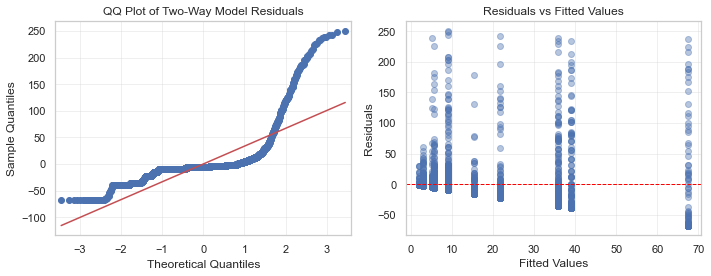

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sm.ProbPlot(residuals).qqplot(line="s", ax=axes[0])
axes[0].set_title("QQ Plot of Two-Way Model Residuals")
axes[0].grid(True, alpha=0.3)
axes[1].scatter(model_interaction.fittedvalues, residuals, alpha=0.4)
axes[1].axhline(0, color="red", linestyle="--", linewidth=1)
axes[1].set_title("Residuals vs Fitted Values")
axes[1].set_xlabel("Fitted Values")
axes[1].set_ylabel("Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()

### Rider Count Sanity Check
A quick unique rider count anchors the discussion when referencing repeated measures or ICC magnitudes.

In [25]:
# count unique riders
num_riders = df["all_riders"].nunique()
print(f"Number of unique riders: {num_riders}")

Number of unique riders: 184
